# Quick notebook of tidal analysis examples for Alena

The first part is re-creating the two examples from the UTide documentation page. The second part grabs real tide gauge data for NZ.

List of packages needed:
- UTide
- numpy
- pandas
- netCDF4
- matplotlib
- datetime (part of standard library)

--------------------------------------------------------------

## Part I
### Test case for using UTide in Python to do tidal analysis.

This just re-creates what's in the notebook found in the UTide package documentation, which can be found [here](https://nbviewer.org/github/wesleybowman/UTide/tree/master/notebooks/).


In [2]:
%pip install utide

%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utide


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.vgt.vito.be/api/pypi/python-packages/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 74.7 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: /opt/conda/envs/baseline/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### First example: reading timeseries data from file and conducting analysis.

In [3]:
# Open file and read data, print first five lines
with open("can1998.dtf") as f:
    lines = f.readlines()

print("".join(lines[:5]))

         0 1998  1  1  0.0000     1.200 0
      3600 1998  1  1  1.0000     1.430 0
      7200 1998  1  1  2.0000     1.730 0
     10800 1998  1  1  3.0000     2.030 0
     14400 1998  1  1  4.0000     2.380 0



In [4]:
# Construct Pandas DataFrame from file using read_csv function
names = ["seconds", "year", "month", "day", "hour", "elev", "flag"]
obs = pd.read_csv(
    "can1998.dtf",
    names=names,
    skipinitialspace=True,
    delim_whitespace=True,
    na_values="9.990",
)

# Good example of using Pandas to infer datetime object, then remove extra columns
date_cols = ["year", "month", "day", "hour"]
index = pd.to_datetime(obs[date_cols])
obs = obs.drop(date_cols, axis=1)
obs.index = index

obs.head(5)

,seconds,elev,flag
1998-01-01 00:00:00,0,1.20,0
1998-01-01 01:00:00,3600,1.43,0
1998-01-01 02:00:00,7200,1.73,0
1998-01-01 03:00:00,10800,2.03,0
1998-01-01 04:00:00,14400,2.38,0


In [5]:
# Some QC from the example
bad = obs["flag"] == 2
corrected = obs["flag"] == 1

obs.loc[bad, "elev"] = np.nan
obs["anomaly"] = obs["elev"] - obs["elev"].mean()
obs["anomaly"] = obs["anomaly"].interpolate()
print(f"{bad.sum()} points were flagged 'bad' and interpolated")
print(f"{corrected.sum()} points were flagged 'corrected' and left unchanged")

10 points were flagged 'bad' and interpolated
212 points were flagged 'corrected' and left unchanged


In [6]:
# Now to actually call UTide to solve for least-square fit of Amp/Phase of constituents
coef = utide.solve(
    obs.index,
    obs["anomaly"],
    lat=-25,
    method="ols",
    conf_int="MC",
    verbose=False,
)

In [7]:
print(coef.keys())

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])


The above output shows that the coef dictionary includes (among other things):
- name, the name of the constituent (e.g. M2, S1, etc.)
- aux, auxiliary info about the setup. One interest part is coef['aux']['frq'], which has the frequencies of each constituent in cph, or cycle per hour
- A, which is the amplitude of each constituent
- g, which is the phase of each constituent [0-360 degrees]

The tidal solution is then real part of the sum:
$\sum_{n=1}^{N_c} A_n \cdot e^{i g}$

Where $N_c$ is the number of constituents.
N.B. that by default UTide includes nodal corrections, you can specify this to be false.


In [8]:
tide = utide.reconstruct(obs.index, coef, verbose=False)

In [9]:
print(tide.keys())

dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])


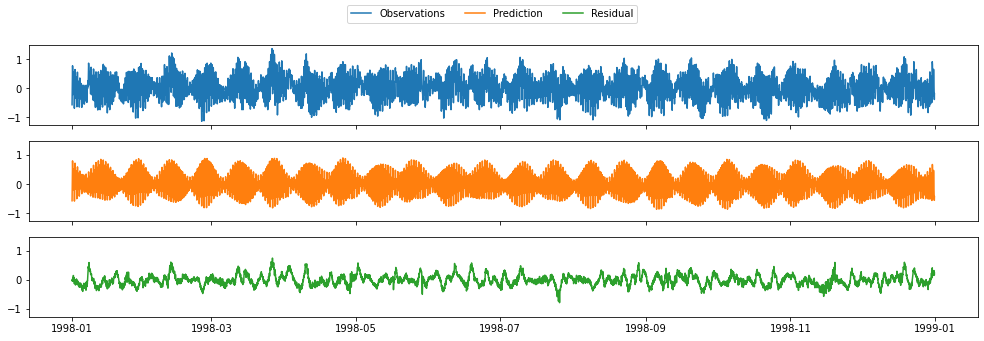

In [10]:
t = obs.index.to_pydatetime()

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.anomaly, label="Observations", color="C0")
ax1.plot(t, tide.h, label="Prediction", color="C1")
ax2.plot(t, obs.anomaly - tide.h, label="Residual", color="C2")
fig.legend(ncol=3, loc="upper center");

### Second example: generating synthetic u/v and conducting analysis.

In [11]:
# U/V fake tide example from second jupyter notebook
def fake_tide(t, M2amp, M2phase):
    """
    Generate a minimally realistic-looking fake semidiurnal tide.
    
    t is time in hours
    phases are in radians
    
    Modified from: http://currents.soest.hawaii.edu/ocn760_4/_static/plotting.html
    """
    return M2amp * np.sin(2 * np.pi * t / 12.42 - M2phase)

from pandas import date_range

N = 500

t = date_range(start="2016-03-29", periods=N, freq="H")

# Signal + some noise.
u = fake_tide(np.arange(N), M2amp=2, M2phase=0) + np.random.randn(N)
v = fake_tide(np.arange(N), M2amp=1, M2phase=np.pi) + np.random.randn(N)

In [12]:
coef = utide.solve(
    t, u, v,
    lat=-42.5,
    nodal=False,
    trend=False,
    method='ols',
    conf_int='linear',
    Rayleigh_min=0.95,
)

solve: matrix prep ... solution ... done.


In [13]:
tide = utide.reconstruct(t, coef)

prep/calcs ... done.


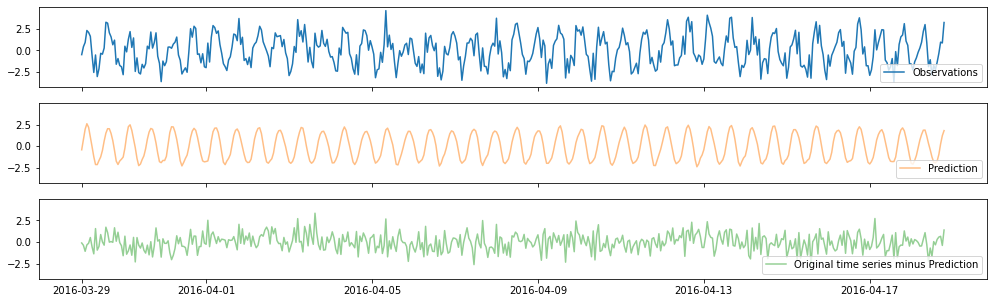

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(t, u, label='Observations', color='C0')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(t, tide['u'], alpha=0.5, label='Prediction', color='C1')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(t, u-tide['u'], alpha=0.5, label='Original time series minus Prediction', color='C2')
ax2.legend(numpoints=1, loc='lower right');

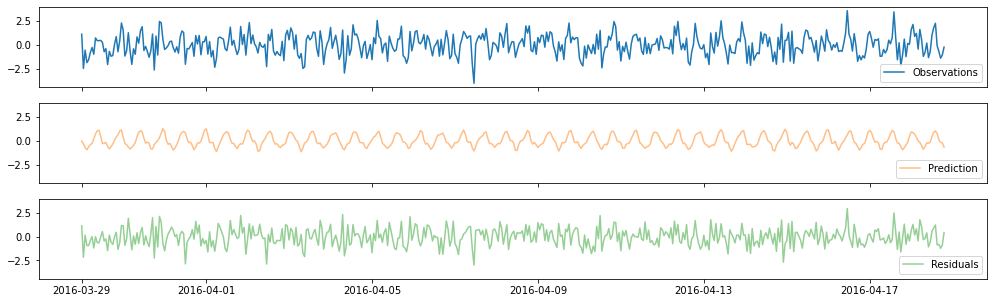

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(t, v, label='Observations', color='C0')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(t, tide['v'], alpha=0.5, label='Prediction', color='C1')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(t, v-tide['v'], alpha=0.5, label='Residuals', color='C2')
ax2.legend(numpoints=1, loc='lower right');

-----------------------------------------------------

## Part II

### Real example from tide gauge in NZ

In [16]:
## Load data from global dataset, extract guage data from station in NZ
from netCDF4 import Dataset
from datetime import datetime, timedelta

# Open netCDF file
dF = Dataset("global_hourly_rqds_c7f6_eed6_a16d_U1684979050431.nc")

# Get list of station names
stationList = np.unique(dF['station_name'])
print(stationList)


['Auckland' 'Bluff' 'Gisborne' 'Jackson' 'Lyttelton' 'Marsden Point'
 'Napier' 'Nelson' 'Port Chalmers' 'Taranaki' 'Tauranga' 'Timaru'
 'Wanganui' 'Wellington' 'West Port']


In [17]:
# Let's grab data from Taranaki to run the analysis...
# Time is seconds from 1970-01-01T00:00:00, so construct datetime from that
t0 = datetime(1970,1,1,0,0,0)
time = np.asarray([t0 + timedelta(seconds=x) for x in np.ma.filled(dF['time'],fill_value=np.nan)])

# Grab indices that correspond to Taranaki, make into data vectors
iTaranaki = np.where(dF['station_name'][:] == 'Taranaki')[0]

tTaranaki = time[iTaranaki]
sshTaranaki = dF['sea_level'][iTaranaki]/1000 # Convert to m instead of mm

# Sort the indices by time...
iSort = np.argsort(time[iTaranaki])
tTaranaki = tTaranaki[iSort]
sshTaranaki = sshTaranaki[iSort]

# Remove extremum where ssh >8 m
sshTaranaki[sshTaranaki>8] = np.nan

In [18]:
# Solve using UTIDE....
coef = utide.solve(
    tTaranaki,
    sshTaranaki,
    lat=-39.05,
    method="ols",
    conf_int="MC",
    verbose=True,
)

solve: matrix prep ... solution ... done.


In [19]:
tide = utide.reconstruct(tTaranaki, coef)

prep/calcs ... done.


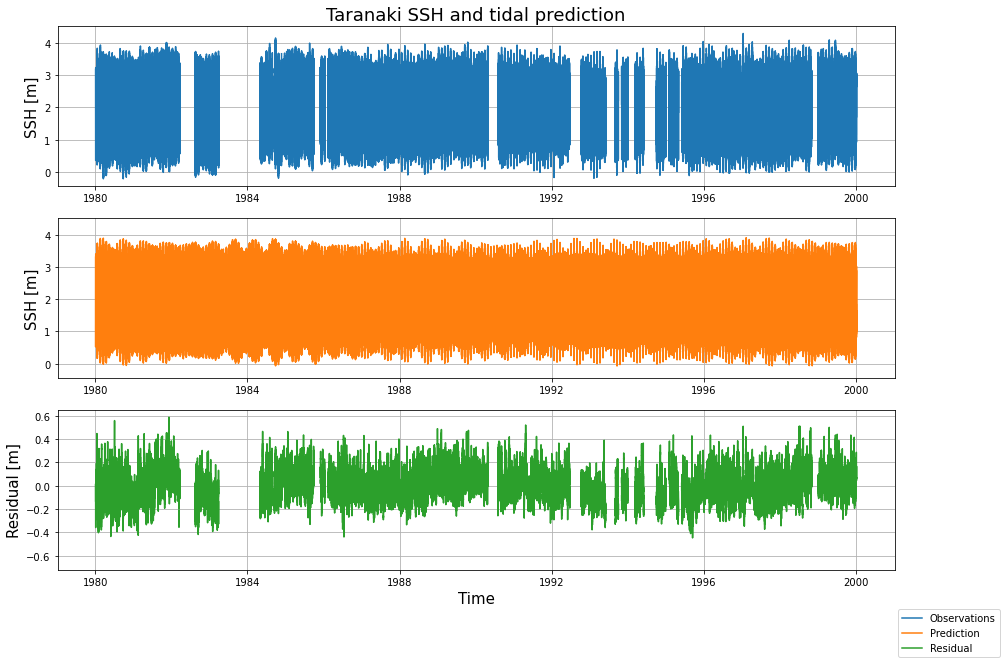

In [20]:
fig = plt.figure(1)
fig.set_size_inches([15,10])
plt.subplot(3,1,1)
plt.plot(tTaranaki,sshTaranaki,color='C0',label='Observations')
plt.ylabel('SSH [m]',fontsize=15)
plt.grid()
Ax = plt.axis()
plt.title('Taranaki SSH and tidal prediction',fontsize=18)

plt.subplot(3,1,2)
plt.plot(tide['t_in'],tide['h'],color='C1',label='Prediction')
#iOverlap = np.where(tide['t_in']==tTaranaki)[0]
plt.ylabel('SSH [m]',fontsize=15)
plt.grid()
plt.axis(Ax)

plt.subplot(3,1,3)
#plt.plot(tide['t_in'][iOverlap],sshTaranaki-tide['h'],'r',label='Residual')
plt.plot(tide['t_in'],sshTaranaki-tide['h'],color='C2',label='Residual')
plt.ylabel('Residual [m]',fontsize=15)
plt.grid()
plt.xlabel('Time',fontsize=15)
#plt.axis([-0.5,0.5,Ax[2],Ax[3])
fig.legend(loc='lower right')



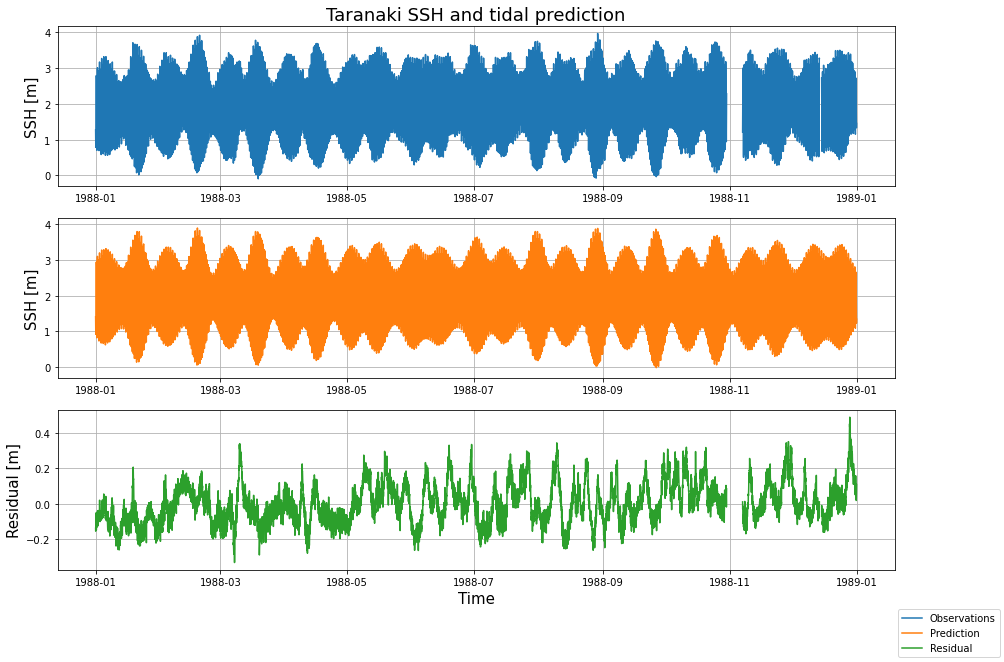

In [21]:
# Same as figure above, but zoomed into 1988
iT1 = np.searchsorted(tTaranaki,datetime(1988,1,1,0,0,0))
iT2 = np.searchsorted(tTaranaki,datetime(1989,1,1,0,0,0))

fig = plt.figure(1)
fig.set_size_inches([15,10])
plt.subplot(3,1,1)
plt.plot(tTaranaki[iT1:iT2],sshTaranaki[iT1:iT2],color='C0',label='Observations')
plt.ylabel('SSH [m]',fontsize=15)
plt.grid()
Ax = plt.axis()
plt.title('Taranaki SSH and tidal prediction',fontsize=18)

plt.subplot(3,1,2)
plt.plot(tide['t_in'][iT1:iT2],tide['h'][iT1:iT2],color='C1',label='Prediction')
plt.ylabel('SSH [m]',fontsize=15)
plt.grid()
plt.axis(Ax)

plt.subplot(3,1,3)
plt.plot(tide['t_in'][iT1:iT2],sshTaranaki[iT1:iT2]-tide['h'][iT1:iT2],color='C2',label='Residual')
plt.ylabel('Residual [m]',fontsize=15)
plt.grid()
plt.xlabel('Time',fontsize=15)
fig.legend(loc='lower right')


In [22]:
# Now let's do prediction!

# hourly timeseries for month of August 2024
tOrigin = datetime(2024,8,1,0,0)
tPred = np.asarray([tOrigin + timedelta(hours=x) for x in range(31*24)])

tidePred = utide.reconstruct(tPred, coef)

prep/calcs ... done.


Text(0.5, 1.0, 'Tidal Prediction, Taranaki Aug 2024')

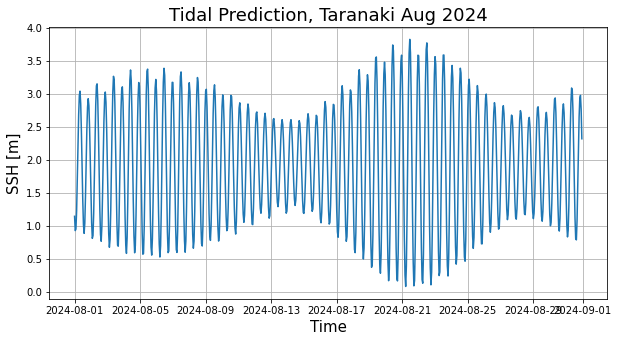

In [23]:
fig = plt.figure()
fig.set_size_inches([10,5])
plt.plot(tPred,tidePred['h'],color='C0')
plt.grid()
plt.xlabel('Time',fontsize=15)
plt.ylabel('SSH [m]',fontsize=15)
plt.title('Tidal Prediction, Taranaki Aug 2024',fontsize=18)

https://sealevel-data.linz.govt.nz/index.html?tidegauge=NBRT

https://www.seanoe.org/data/00652/76439/

https://www.pmel.noaa.gov/ocs/data/disdel/ (Papa, hourly vs daily vs monthly)


